### 1. 데이터 구하기
---

- 데이터: 미국 나스닥

In [2]:
import pandas as pd
import os

csv_file = os.getenv('HOME')+'/project/aiffel/e/e20/nasdaq/nasdaq.csv'
df = pd.read_csv(csv_file)
df.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-09-18,3721.0,3785.5,3602.0,3653.5,3653.5,72994.0
1,2000-09-19,3658.5,3817.0,3656.0,3804.0,3804.0,70029.0


In [4]:
df.loc[:,'Date'] = pd.to_datetime(df.Date)
df.isna().sum()

Date            0
Open         1072
High         1072
Low          1072
Close        1072
Adj Close    1072
Volume       1072
dtype: int64

In [5]:
print('삭제 전 데이터길이: ', len(df))

df = df.dropna(axis=0).reset_index(drop=True)
print('삭제 후 데이터길이: ', len(df))
df.isna().sum()

삭제 전 데이터길이:  6170
삭제 후 데이터길이:  5098


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### 2. 기본 통계분석으로 이상치 찾기
---

- 데이터의 분포 그려보기
- z-test로 정규분포를 만족하는지 확인하기
- (정규분포를 만족하지 않으면) Time series decompose 수행 후 residual 분석하기

한 단계 더 나 아가기
- 왜 이상치로 분류됐는지 해석해보기
- 탐지해낸 이상치는 극단치인지, 특이치인지 생각해보기
- 이상치들을 제거/교정해야할지 내버려둘지 고민하기

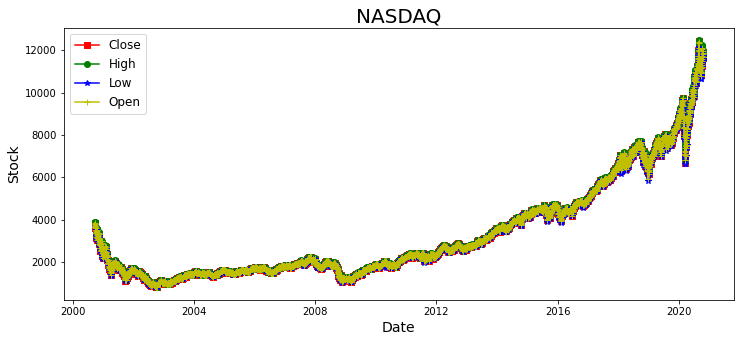

In [7]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.rcParams["figure.figsize"] = (12,5)

plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('NASDAQ', fontsize=20)
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=12, loc='best')

plt.show()

그냥 그려보았을 때는, 뚜렷한 이상치가 보이지는 않는다.

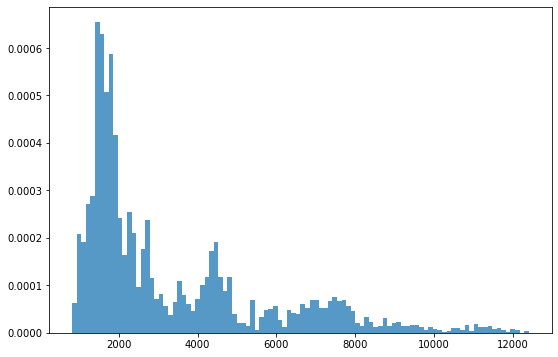

In [9]:
%matplotlib inline
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(df.Close,100,density=True,alpha=0.75)

데이터의 분포가 표준분포와는 거리가 멀다는 것을 알 수 있다.

In [10]:
from statsmodels.stats.weightstats import ztest

_,p = ztest(df.Close)
print(p)

0.0


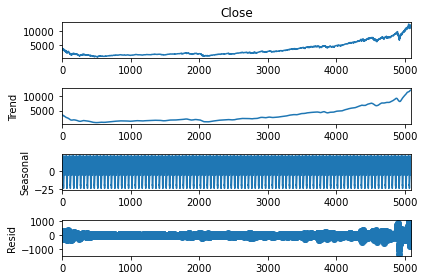

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df.Close, model='additive', two_sided=True,
                           period=50, extrapolate_trend='freq')
result.plot()
plt.show()

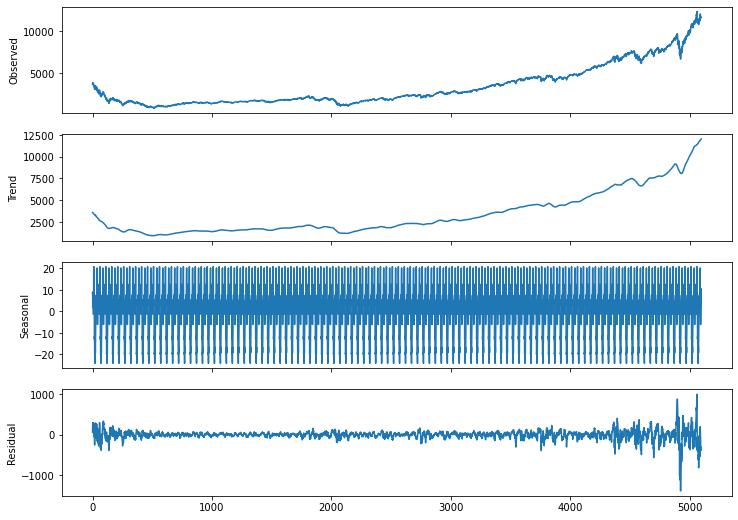

In [12]:
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,9))
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

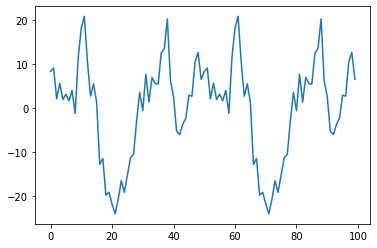

In [13]:
result.seasonal[:100].plot()

seasonal은 -30~20 사이를 주기적으로 반복함

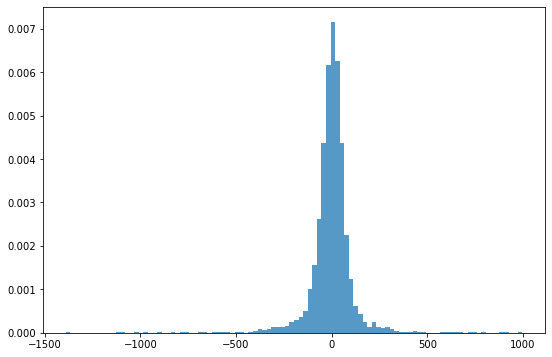

In [15]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(result.resid, 100, density=True, alpha=0.75)

In [16]:
r = result.resid.values
st, p = ztest(r)
print(st, p)

-0.8390076883668396 0.40146499522520807


p값이 04로 데이터의 잔차가 정규분포를 따르고 있음을 알 수 있다.

In [18]:
mu, std = result.resid.mean(), result.resid.std()
print("평균: ", mu, "표준편차: ", std)

print('이상치: ', len(result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)]))

평균:  -1.2913972051412874 표준편차:  109.89901935436704
이상치:  92


In [19]:
df.Date[result.resid[
    (result.resid>mu+3*std)|(result.resid<mu-3*std)
].index]

66     2000-12-20
73     2001-01-02
91     2001-01-29
92     2001-01-30
136    2001-04-03
          ...    
5083   2020-10-05
5084   2020-10-06
5085   2020-10-07
5096   2020-10-22
5097   2020-10-23
Name: Date, Length: 92, dtype: datetime64[ns]

이상치의 개수가 너무 많아 하나씩 들여다보기 힘들다.
따라서 Clustering으로 이상치들을 그룹지을 것이다.

### 3. Unsupervised Clustering으로 이상치찾기
---
- k-means로 분석하기
- DBSCAN으로 분석하기

한 단계 더 나아가기
- 왜 이상치로 분류됐는지 해석해보기
- 탐지해낸 이상치는 극단치인지, 특이치인지 생각해보기
- 이 이상치를 제거/교정해야할지 내버려둘지 고민하기

In [20]:
def my_decompose(df, features, freq=50):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    for f in features:
        result = seasonal_decompose(df[f],model='additive', period=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
    
    return trend, seasonal, resid

tdf, sdf, rdf = my_decompose(df, features=['Open', 'High', 'Low', 'Close', 'Volume'])
tdf.describe()

,Open,High,Low,Close,Volume
count,5098.000000,5098.000000,5098.000000,5098.000000,5098.000000
mean,3330.724999,3362.220146,3298.532406,3332.609090,288057.188854
std,2400.892883,2422.863050,2379.665832,2404.825139,109834.091507
min,914.415000,934.695000,895.770000,915.335000,64880.520000
25%,1584.407500,1597.671250,1571.153750,1584.352001,220586.700000
50%,2264.797500,2292.105000,2232.207500,2265.174199,268932.110000
75%,4434.168125,4466.316875,4401.132500,4435.347500,319674.830000
max,12039.860297,12201.437499,11870.369861,12047.090432,776809.340000


In [21]:
sdf.describe()

,Open,High,Low,Close,Volume
count,5098.000000,5098.000000,5098.000000,5098.000000,5098.000000
mean,-0.005084,-0.003891,-0.004557,-0.003745,4.370591
std,11.363539,10.507054,11.994906,11.241935,14514.475482
min,-25.238614,-25.344171,-27.703917,-24.070805,-35400.160583
25%,-5.422809,-6.246186,-8.593132,-6.193296,-11598.915336
50%,2.150852,3.141061,2.582667,2.462381,-599.165008
75%,6.705393,5.777104,7.909121,6.845566,10146.617569
max,22.388372,20.105635,20.204707,20.901232,34512.718482


In [23]:
rdf.describe()

,Open,High,Low,Close,Volume
count,5098.000000,5098.000000,5098.000000,5098.000000,5098.000000
mean,-1.361168,-1.421971,-1.241082,-1.314223,155.136515
std,112.249407,102.051145,116.463672,110.054996,110706.241180
min,-1280.580676,-1494.706438,-1226.976539,-1390.196689,-602731.340129
25%,-38.117788,-35.393102,-38.318769,-37.788724,-53311.671523
50%,3.476876,3.331959,4.089242,2.923191,-488.997470
75%,40.164011,37.638459,41.675332,40.863314,51480.694345
max,996.954616,933.609579,944.823580,996.320780,810713.135421


Volume의 크기만 너무 크기 때문에, 각 변수들을 표준 정규화한다

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(rdf)

print(scaler.mean_)
norm_rdf = scaler.transform(rdf)
norm_rdf

[ -1.36116811  -1.42197139  -1.24108161  -1.31422283 155.13651478]


array([[ 0.94892246,  0.84646493,  0.81728626,  0.60184276,  0.08322602],
       [ 0.49026957,  1.28420778,  1.38842808,  2.09551792,  0.10454779],
       [ 1.90750707,  2.01838985,  2.0481367 ,  2.7378712 , -0.08888583],
       ...,
       [-2.9355638 , -3.75950684, -2.18973446, -2.93558305,  0.44805172],
       [-3.02900188, -4.45234664, -3.01260131, -3.46542972,  0.39484453],
       [-3.32615554, -5.03188414, -2.82731937, -3.56760069,  0.48127544]])

### K-means

In [25]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(norm_rdf)
print(kmeans.labels_)

[1 1 1 ... 0 0 0]


In [26]:
lbl, cnt = np.unique(kmeans.labels_, return_counts=True)
print(lbl)
print(cnt)

[0 1]
[1099 3999]


각 그룹의 크기가 너무 크기 때문에, 그룹의 숫자를 더 늘려서 분석한다.

In [35]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_, return_counts=True,)
['group:{} - count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:0 - count:875',
 'group:1 - count:901',
 'group:2 - count:140',
 'group:3 - count:658',
 'group:4 - count:20',
 'group:5 - count:20',
 'group:6 - count:463',
 'group:7 - count:123',
 'group:8 - count:1776',
 'group:9 - count:122']

4, 5그룹이 count 20으로 매우 특이한 그룹으로 분류되었다.

In [38]:
df[(kmeans.labels_ == 4)]

,Date,Open,High,Low,Close,Adj Close,Volume
4591,2018-12-26,5902.000000,6310.000000,5820.500000,6285.500000,6285.500000,642440.0
4916,2020-03-12,7998.750000,8108.000000,7128.500000,7215.250000,7215.250000,876291.0
4917,2020-03-13,7100.000000,7978.000000,6942.500000,7915.750000,7915.750000,584274.0
4918,2020-03-15,7100.000000,7978.000000,6942.500000,7215.250000,7215.250000,578813.0
4919,2020-03-16,7903.000000,7905.250000,6927.000000,7057.500000,7057.500000,307368.0
4920,2020-03-17,7053.000000,7552.250000,6948.750000,7405.250000,7405.250000,317501.0
4921,2020-03-18,7386.000000,7392.250000,6830.000000,7225.250000,7225.250000,156283.0
4922,2020-03-19,7251.750000,7521.500000,6894.250000,7293.500000,7293.500000,115519.0
4923,2020-03-20,7195.000000,7649.000000,7153.500000,7417.979980,7417.979980,562616.0
4924,2020-03-22,6798.000000,6798.000000,6628.750000,6688.750000,6688.750000,321230.0


In [39]:
df[(kmeans.labels_ == 5)]

,Date,Open,High,Low,Close,Adj Close,Volume
4891,2020-02-11,9525.000000,9609.500000,9501.250000,9527.250000,9527.250000,589570.0
4892,2020-02-12,9536.250000,9628.250000,9523.750000,9625.750000,9625.750000,454472.0
4893,2020-02-13,9621.500000,9644.750000,9511.250000,9613.000000,9613.000000,613580.0
4894,2020-02-14,9626.250000,9659.250000,9588.000000,9632.250000,9632.250000,489387.0
4895,2020-02-16,9635.000000,9668.750000,9634.250000,9663.750000,9663.750000,297278.0
4896,2020-02-18,9635.000000,9687.500000,9534.250000,9636.000000,9636.000000,668505.0
4897,2020-02-19,9643.250000,9748.750000,9641.250000,9733.500000,9733.500000,419130.0
4898,2020-02-20,9744.750000,9763.000000,9517.000000,9624.250000,9624.250000,802424.0
4899,2020-02-21,9617.250000,9623.750000,9411.500000,9458.000000,9458.000000,911839.0
4900,2020-02-23,9355.250000,9365.000000,9289.000000,9315.000000,9315.000000,995989.0


In [33]:
pd.DataFrame(kmeans.cluster_centers_, columns=['Open', 'High', 'Low', 'Close', 'Volume'])

,Open,High,Low,Close,Volume
0,-0.680423,-0.695445,-0.644975,-0.637833,0.190856
1,0.702426,0.727348,0.746262,0.740061,-0.300086
2,-0.861048,-0.978225,-1.349246,-1.341650,2.494335
3,0.121115,0.137238,-0.038591,-0.005473,1.094947
4,-7.045166,-6.755078,-7.242254,-6.732399,-0.888411
5,6.079321,6.124428,6.126568,6.046373,-0.222580
6,-0.051793,-0.066174,0.026852,0.008738,-1.642205
7,-2.608932,-2.722578,-2.569650,-2.558633,0.280741
8,0.053887,0.055169,0.083944,0.073865,-0.103680
9,2.259162,2.326986,2.346987,2.288671,-0.261610


Volume을 제외한 값들이 4번그룹에서는 매우 작게, 5번그룹에서는 매우 크게 나타난다.

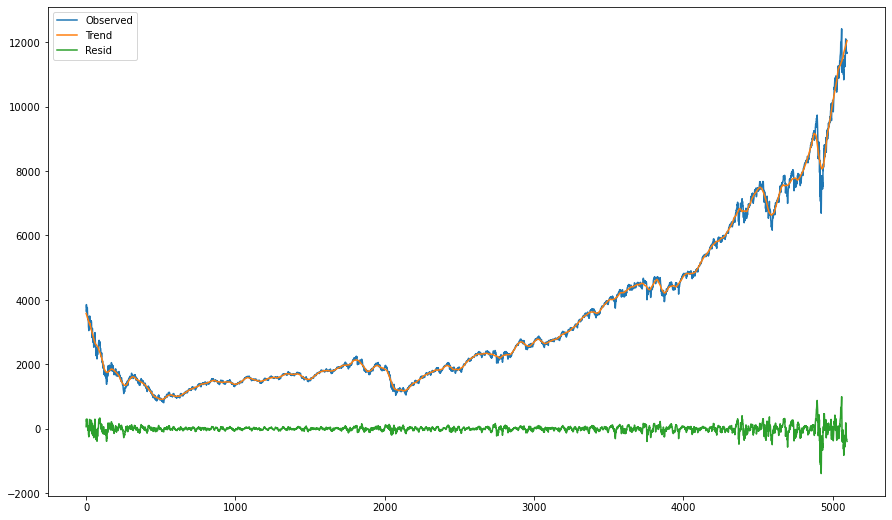

In [37]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
df.Close.plot(ax=ax, label='Observed', legend=True)
tdf.Close.plot(ax=ax, label='Trend', legend=True)
rdf.Close.plot(ax=ax, label='Resid', legend=True)
plt.show()

COVID19 때문에 발생한 올해 3월의 폭락과 그 후 회복세를 보인 8월부터의 폭등으로 인한 이상치임을 알 수 있다.

### DBSCAN

In [45]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.7, min_samples=5).fit(norm_rdf)
print(clustering.labels_)

[ 0  0  0 ... -1 -1 -1]


In [46]:
lbl, cnt = np.unique(clustering.labels_, return_counts=True)
['group:{} - count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:-1 - count:263',
 'group:0 - count:4816',
 'group:1 - count:7',
 'group:2 - count:4',
 'group:3 - count:4',
 'group:4 - count:4']

DBSCAN을 그룹을 총 6개로 분류했고 그 중 네개의 그룹이 이상그룹이다.

### 4. LSTM 오토인코더로 이상치찾기
---
- 딥러닝을 위한 데이터셋 만들기
- 오토인코더 모델 생성하기
- 학습이 정상적으로 수행됐는지 확인하기

한 단계 더 나아가기
- 앞선 두가지 방법과 비교하기
- 다른 이유가 뭔지 확인해보기
- 더 나은 형태의 오토인코더 모델을 만들어보기

In [49]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

tf.random.set_seed(777)
np.random.seed(777)

In [51]:
from sklearn.preprocessing import StandardScaler

window_size = 10
batch_size = 32
features = ['Open', 'High', 'Low', 'Close', 'Volume']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

sacler = StandardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE, features].values)
scaled = scaler.transform(df[features].values)

In [52]:
train_gen = TimeseriesGenerator(
    data=scaled,
    targets=scaled,
    length=window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data=scaled,
    targets=scaled,
    length=window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)
print(train_gen[0][1].shape)

(32, 10, 5)
(32, 5)


In [54]:
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(window_size, n_features)),
    LSTM(16, activation='relu', return_sequences=False),
    RepeatVector(window_size),
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10, 64)            17920     
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                5184      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 16)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 16)            2112      
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 46,277
Trainable params: 46,277
Non-trainable params: 0
____________________________________________________

In [63]:
import os

checkpoint_path = os.getenv('HOME')+'/project/aiffel/e/e20/nasdaq/mymodel.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                            save_weights_only=True,
                            save_best_only=True,
                            monitor='val_loss',
                            verbose=1
                            )

early_stop = EarlyStopping(monitor='val_loss', patience=10)

model.compile(loss='mae', optimizer='adam', metrics=['mae'])

In [64]:
hist = model.fit(train_gen,
                validation_data=valid_gen,
                steps_per_epoch=len(train_gen),
                validation_steps=len(valid_gen),
                epochs=50,
                callbacks=[checkpoint, early_stop]
                )

Epoch 1/50
158/159 [============================>.] - ETA: 0s - loss: 0.2703 - mae: 0.2703
Epoch 00001: val_loss improved from inf to 0.58342, saving model to /home/aiffel0042/project/aiffel/e/e20/nasdaq/mymodel.ckpt
159/159 [==============================] - 5s 30ms/step - loss: 0.2717 - mae: 0.2717 - val_loss: 0.5834 - val_mae: 0.5834
Epoch 2/50
158/159 [============================>.] - ETA: 0s - loss: 0.3017 - mae: 0.3017
Epoch 00002: val_loss did not improve from 0.58342
159/159 [==============================] - 4s 28ms/step - loss: 0.3006 - mae: 0.3006 - val_loss: 0.6461 - val_mae: 0.6461
Epoch 3/50
158/159 [============================>.] - ETA: 0s - loss: 0.2645 - mae: 0.2645
Epoch 00003: val_loss improved from 0.58342 to 0.38177, saving model to /home/aiffel0042/project/aiffel/e/e20/nasdaq/mymodel.ckpt
159/159 [==============================] - 5s 28ms/step - loss: 0.2650 - mae: 0.2650 - val_loss: 0.3818 - val_mae: 0.3818
Epoch 4/50
159/159 [==============================] - 

159/159 [==============================] - ETA: 0s - loss: 0.2178 - mae: 0.2178
Epoch 00030: val_loss did not improve from 0.25769
159/159 [==============================] - 5s 28ms/step - loss: 0.2178 - mae: 0.2178 - val_loss: 0.2973 - val_mae: 0.2973
Epoch 31/50
159/159 [==============================] - ETA: 0s - loss: 0.1838 - mae: 0.1838
Epoch 00031: val_loss did not improve from 0.25769
159/159 [==============================] - 4s 28ms/step - loss: 0.1838 - mae: 0.1838 - val_loss: 0.2988 - val_mae: 0.2988


In [65]:
model.load_weights(checkpoint_path)

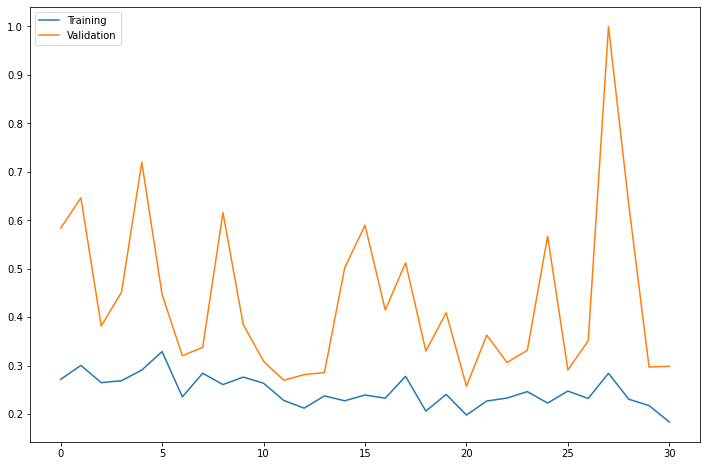

In [66]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

Validation loss가 널뛰는 경향을 보이고 Training loss는 전반적으로 줄어들고 있다.

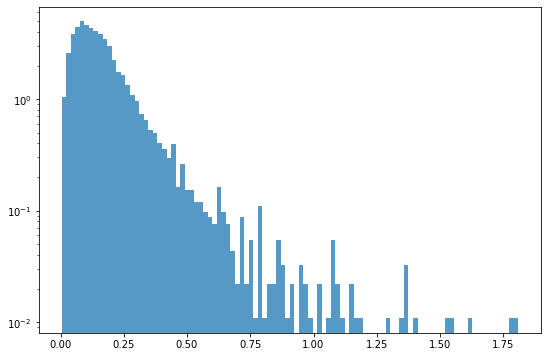

In [67]:
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

mae_loss 1.25를 기준으로 분석

In [69]:
import copy

test_df = copy.deepcopy(df.loc[window_size:]).reset_index(drop=True)
test_df['Loss'] = mae_loss

threshold = 1.25
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
4580,2018-12-21,6307.50,6317.75,6242.00,6257.250000,6257.250000,862689.0,1.363109
4892,2020-02-25,9091.00,9224.25,8810.00,8854.250000,8854.250000,1344897.0,1.370574
4893,2020-02-26,8868.25,9037.50,8709.50,8850.250000,8850.250000,1251412.0,1.551188
4894,2020-02-27,8811.50,8878.50,8334.25,8382.750000,8382.750000,1580041.0,1.808378
4895,2020-02-28,8347.00,8574.75,8126.25,8454.000000,8454.000000,1527204.0,1.788305
4896,2020-03-01,8347.00,8574.75,8126.25,8382.750000,8382.750000,1513887.0,1.621462
4897,2020-03-02,8349.25,8883.25,8224.25,8791.250000,8791.250000,1373357.0,1.524932
4898,2020-03-03,8830.50,9002.50,8511.00,8582.500000,8582.500000,1295648.0,1.358788
4920,2020-03-29,7395.75,7507.25,7367.25,7489.250000,7489.250000,1256384.0,1.346886
4930,2020-04-12,8296.00,8327.50,8073.25,8115.750000,8115.750000,1224003.0,1.408171


/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


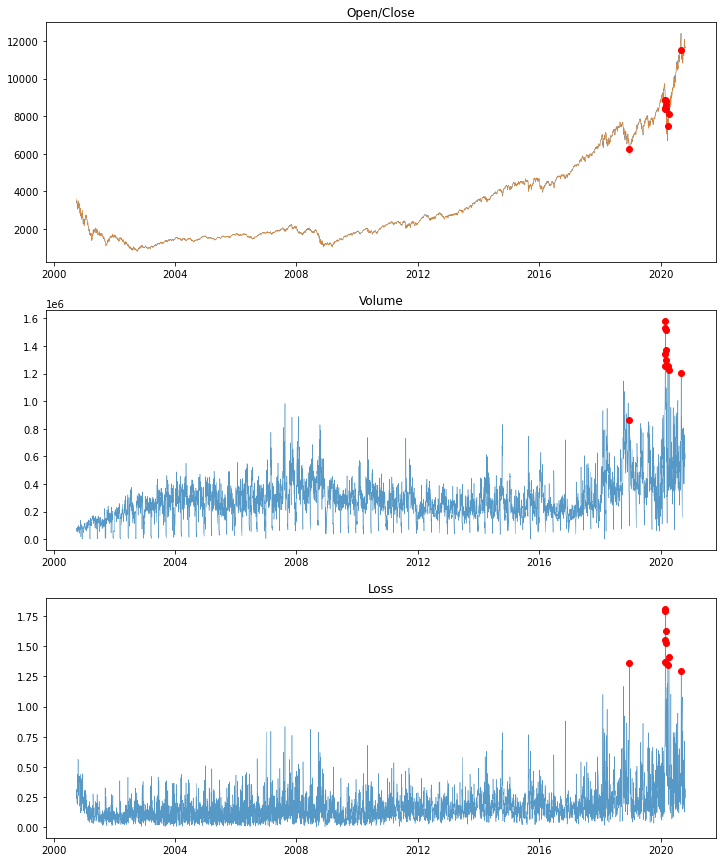

In [70]:
fig = plt.figure(figsize=(12, 15))

ax = fig.add_subplot(311)
ax.set_title('Open/Close')
plt.plot(test_df.Date, test_df.Close, linewidth=0.5, alpha=0.75, label='Close')
plt.plot(test_df.Date, test_df.Open, linewidth=0.5, alpha=0.75, label='Open')
plt.plot(test_df.Date, test_df.Close, 'or', markevery=[mae_loss>threshold])

ax = fig.add_subplot(312)
ax.set_title('Volume')
plt.plot(test_df.Date, test_df.Volume, linewidth=0.5, alpha=0.75, label='Volume')
plt.plot(test_df.Date, test_df.Volume, 'or', markevery=[mae_loss>threshold])

ax = fig.add_subplot(313)
ax.set_title('Loss')
plt.plot(test_df.Date, test_df.Loss, linewidth=0.5, alpha=0.75, label='Loss')
plt.plot(test_df.Date, test_df.Loss, 'or', markevery=[mae_loss>threshold])

### Report

In [ ]:
- 앞서 k-means로 분석한 이상치 그룹 중 첫번째 그룹의 일부와 두번째 그룹 중 하나만 오토인코더가 찾아냄
- 오토인코더의 validation 학습이 제대로 되지 않은 느낌
